# Rating prediction based on k-nearest neighbors 

This script predicts ratings using similarity metrics produced by LSI, the whole analysis is on the training set, a separate script will deal with test set prediction

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import re
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import unidecode
%matplotlib inline
import copy
from time import time

In [50]:
from gensim import corpora,models,similarities
from sklearn.cross_validation import KFold
from collections import defaultdict
from time import time
from itertools import product
import itertools

## 1. Load similarity matrices and ratings

### 1.1 Load LSI corpuses with different num of topics

In [3]:
corpustrain_lsi_50 = corpora.MmCorpus('./data/corpustrain_lsi.mm')
corpustrain_lsi_20 = corpora.MmCorpus('./data/corpustrain_lsi_20.mm')
corpustrain_lsi_25 = corpora.MmCorpus('./data/corpustrain_lsi_25.mm')
corpustrain_lsi_30 = corpora.MmCorpus('./data/corpustrain_lsi_30.mm')
corpustrain_lsi_40 = corpora.MmCorpus('./data/corpustrain_lsi_40.mm')

In [59]:
corpuslist = [corpustrain_lsi_20,corpustrain_lsi_25,corpustrain_lsi_30,corpustrain_lsi_40,
             corpustrain_lsi_50]

In [4]:
sp_corpustrain_lsi_50 = corpora.MmCorpus('./data/sp_corpustrain_lsi.mm')
sp_corpustrain_lsi_20 = corpora.MmCorpus('./data/sp_corpustrain_lsi_20.mm')
sp_corpustrain_lsi_25 = corpora.MmCorpus('./data/sp_corpustrain_lsi_25.mm')
sp_corpustrain_lsi_30 = corpora.MmCorpus('./data/sp_corpustrain_lsi_30.mm')
sp_corpustrain_lsi_40 = corpora.MmCorpus('./data/sp_corpustrain_lsi_40.mm')

In [60]:
sp_corpuslist = [sp_corpustrain_lsi_20,sp_corpustrain_lsi_25,sp_corpustrain_lsi_30,
                sp_corpustrain_lsi_40,sp_corpustrain_lsi_50]

### 1.2 Load the training dataframe 

Other than the topic similarity, speaker_gender can be used as a baseline. There are other features stored in the captions_f.json, such as length of the talk, talking speed, num of paragraph etc., however as they are numerical values, are not incorporated into the current neighborhood based method

In [5]:
train = pd.read_json('train3.json')

In [6]:
train.sort_values(by = 'id',inplace = True)

In [7]:
train.reset_index(drop = True, inplace = True)

In [8]:
train.shape

(1531, 33)

In [9]:
ids = train['id']

In [11]:
trainset = list(ids)

In [12]:
trainset.sort()

In [13]:
trainset = np.array(trainset)

In [14]:
len(trainset)

1531

#### Set up function to extract similar talks 

In [15]:
iddict = dict([(item[1],item[0]) for item in ids.iteritems()])

In [16]:
rowdict = dict([(item[0],item[1]) for item in ids.iteritems()])

In [19]:
def give_similar_talks(talkid,corpus,index,trainset,num_of_talks = 10):
    """
    inputs: talkid,corpus,num_of_talks,index
            trainset: a series of ids
    outputs:
            a list of tuples, (talkid, cosine similarity score in descending order)
    """
    tmpset = set(trainset).difference(set([talkid])) # remove the target talk itself if it presents
    sims = index[corpus[iddict[talkid]]]
    sims = sorted(enumerate(sims),reverse = True, key = lambda x:x[1])
    res = []
    ctr = 0
    for key,value in sims:
        if rowdict[key] in tmpset:
            res.append((rowdict[key],value))
            ctr += 1
        if ctr >= num_of_talks:
            break
    return res

In [20]:
index = similarities.MatrixSimilarity(corpustrain_lsi_50)

In [23]:
sp_index = similarities.MatrixSimilarity(sp_corpustrain_lsi_50)

In [22]:
give_similar_talks(1666,corpustrain_lsi_50,index,ids,10)

[(1672, 0.9052946),
 (1954, 0.90312833),
 (1403, 0.86130905),
 (930, 0.78333473),
 (751, 0.77572221),
 (1646, 0.7608012),
 (1120, 0.76032686),
 (704, 0.74961346),
 (2110, 0.74808681),
 (1053, 0.73183328)]

##### give similar talks based on speaker info 

In [24]:
give_similar_talks(1666,sp_corpustrain_lsi_50,sp_index,ids,10)

[(1672, 0.92408538),
 (1248, 0.81673884),
 (1954, 0.80270743),
 (1031, 0.79996693),
 (1646, 0.74974966),
 (1734, 0.73386347),
 (2152, 0.72371781),
 (1732, 0.70604813),
 (809, 0.68890679),
 (1728, 0.67879176)]

## 2. Neighborhood based model construction 

The model is straightforward at this point, I use $\hat Y_{i} $ to represent the estimated rating of talk i, it equals to the gender baseline ($\bar Y_{f(m)i}$ ) plus weighted average ratings from similar talks based on topic and speaker background, the similarity between talks is denoted as $\ s_{ij} $ , which should be a weighted similarity taking into account both the topic and speaker background info

$$ \hat{Y_{i}} = \bar Y_{f(m)i}\, + \,\frac{\sum\limits_{j \in S^{k}(i)} s_{ij} ( Y_{j} - \bar Y_{f(m)j} )}{\sum\limits_{j \in S^{k}(i)} s_{ij} } $$

### 2.1 baseline calculation 

In [25]:
ratings = train.ix[:,:14]

In [26]:
ratings = ratings.fillna(0)

In [27]:
ratingsum_raw = ratings.sum(axis = 1)

#### store ratingwords into a list 

In [28]:
ratingwords = list(ratings.columns)

##### smooth zero counts using Dirichlet prior 

In [29]:
ratings[ratingwords] = ratings[ratingwords]+1

##### convert to proportion 

In [30]:
ratings = ratings[ratingwords].div(ratingsum_raw+14,axis = 'index')

In [31]:
ratings['id'] = train['id']

In [32]:
ratings['ratesum'] = ratingsum_raw + 14

##### calculate the overall mean vector of ratings 

In [33]:
global_mean = ratings[ratingwords].mean()

##### calculate mean difference between male and female speakers 

In [34]:
ratings['gender'] = train['speaker_gender']

In [35]:
ratings.gender.value_counts()

1    1110
0     421
Name: gender, dtype: int64

In [36]:
female_mean = ratings.groupby('gender')[ratingwords].mean().ix[0,:]

In [37]:
male_mean = ratings.groupby('gender')[ratingwords].mean().ix[1,:]

### 2.2 Prediction based on transcripts similarity 

Test the simple model with gender baseline plus the weighted averaged ratings from top k similar talks. The hyperparameters are k (number of neighbors) and number of topics, tuned using cross validation

In [39]:
ratings.ix[iddict[1666],ratingwords]

Beautiful       0.124457
Confusing       0.003618
Courageous      0.303907
Fascinating     0.059334
Funny           0.002894
Informative     0.073082
Ingenious       0.005065
Inspiring       0.345876
Jaw-dropping    0.029667
Longwinded      0.000724
OK              0.005065
Obnoxious       0.002171
Persuasive      0.040521
Unconvincing    0.003618
Name: 1087, dtype: float64

In [40]:
def pred_rating1(talkid,trainset,k,corpus,index):
    """
    given the target talkid, the trainset, the number of similar talks to be selected and the specific corpus with
    selected number of topics (from: 20,25,30,40,50)
    return the prediction as a numpy array
    input: trainset: a numpy series talk ids
           k: (int) number of most similar talks to retrieve,
           corpus: the specific corpus
           index: the corresponding index for the corpus
    output: a numpy array of predicted rating
    """
    sim_talks = give_similar_talks(talkid,corpus,index,trainset,num_of_talks=k)
    weights_sum = sum([sim for num,sim in sim_talks])
    # initialize rating_vect with zeros
    rating_vect = pd.Series(0,index = female_mean.index)
    for sim_talk_id,sim in sim_talks:
        sim_vect = ratings.ix[iddict[sim_talk_id],ratingwords]
        if train.ix[iddict[sim_talk_id],'speaker_gender'] == 0:
             sim_vect -= female_mean
        else:
             sim_vect -= male_mean
        rating_vect += sim_vect*sim
    if len(sim_talks) != 0:
        rating_vect /= weights_sum
    else:
        pass
        # print 'no similar talks is found for talk with id {}, base prediction is used'.format(talkid)
    # gender
    gender = train.ix[iddict[talkid],'speaker_gender']
    if gender == 0:
        rating_vect += female_mean
    else:
        rating_vect += male_mean
    # handle non-positive ratings, truncate them to be positive (0.0001)
    rating_vect = [x if x > 0 else 0.0001 for x in rating_vect]
    rating_vect = pd.Series(rating_vect,index = female_mean.index)
    return rating_vect

In [41]:
def prob_distance(vect1,vect2,dist = 'hellinger'):
    """
    calculate the distance between two probability distributions
    default type is hellinger distance, which is bounded in [0,1]
    the other option is Jensen-shannon distance, which is also bounded in [0,1]
    """
    if dist == 'hellinger':
        return np.sqrt(0.5*sum((np.sqrt(vect1)-np.sqrt(vect2))**2))
    if dist == 'Jensen':
        vectq = 0.5*(vect1+vect2)
        js_div = 0.5*sum(vect1*np.log2(vect1)+vect2*np.log2(vect2))-sum(vectq*np.log2(vectq))
        return np.sqrt(js_div)

In [42]:
predicted = pred_rating1(1666,ids,5,corpustrain_lsi_50,index)

In [43]:
real = ratings.ix[iddict[1666],ratingwords].values

In [44]:
prob_distance(predicted,real,'Jensen')

0.15502837986399401

In [45]:
prob_distance(predicted,real)

0.13092252335076504

#### Test the range of the distance metrics 

In [46]:
talk1 = ratings.ix[iddict[1666],ratingwords].values

In [47]:
talk2 = ratings.ix[iddict[1],ratingwords].values

In [48]:
prob_distance(talk1,talk2,'Jensen')

0.57977383386720038

### Cross-validation to tune k and number of topics

In [49]:
kf = KFold(len(trainset),n_folds = 10,random_state = 321,shuffle=True)

In [65]:
k_values = [3,5,7,10,15,20]
num_topics = xrange(5) # this corresponds to the position of the real number of topics in the list[20,25,30,40,50]
hypergrid = list(itertools.product(k_values,num_topics))
difference_all = defaultdict(list)

t0 = time()
for k,numtp in hypergrid:
    corpus = corpuslist[numtp]
    index = similarities.MatrixSimilarity(corpus)
    cv_difference = []
    for train_index,test_index in kf:
        cv_trainset,cv_testset = ids[train_index],ids[test_index]
        # for each talk in the test set, calculate its rating based on similar talks in the cv_trainset
        # vectorize the operation using Pandas series
        for test_talkid in cv_testset:
            predicted = pred_rating1(test_talkid,cv_trainset,k,corpus,index)
            res = ratings.ix[iddict[test_talkid],ratingwords].values
            difference = prob_distance(predicted,res,'hellinger')
            #cv_ids.append(test_talkid)
            #cv_predicted.append(predicted)
            cv_difference.append(difference)
    difference_all[(k,numtp)] = cv_difference
print 'finished within {} sec'.format(time()-t0)

finished within 488.677018166 sec


In [104]:
k_values = [25,30,40]
num_topics = xrange(5) # this corresponds to the position of the real number of topics in the list[20,25,30,40,50]
hypergrid2 = list(itertools.product(k_values,num_topics))

t0 = time()
for k,numtp in hypergrid2:
    corpus = corpuslist[numtp]
    index = similarities.MatrixSimilarity(corpus)
    cv_difference = []
    for train_index,test_index in kf:
        cv_trainset,cv_testset = ids[train_index],ids[test_index]
        # for each talk in the test set, calculate its rating based on similar talks in the cv_trainset
        # vectorize the operation using Pandas series
        for test_talkid in cv_testset:
            predicted = pred_rating1(test_talkid,cv_trainset,k,corpus,index)
            res = ratings.ix[iddict[test_talkid],ratingwords].values
            difference = prob_distance(predicted,res,'hellinger')
            #cv_ids.append(test_talkid)
            #cv_predicted.append(predicted)
            cv_difference.append(difference)
    difference_all[(k,numtp)] = cv_difference
print 'finished within {} sec'.format(time()-t0)

finished within 674.507706165 sec


In [110]:
difference_all_list = []
for key in difference_all.keys():
    meandiff = sum(difference_all[key])/len(difference_all[key])
    difference_all_list.append((key,meandiff))

In [165]:
sorted(difference_all_list,key = lambda x:x[1])[:10]

[((20, 3), 0.23282784472626136),
 ((25, 3), 0.23322648903218504),
 ((15, 3), 0.23324181502479852),
 ((20, 0), 0.23346633430196487),
 ((30, 3), 0.2335714637784439),
 ((20, 4), 0.23382919050147546),
 ((20, 2), 0.23391249995759031),
 ((15, 0), 0.23397947158566559),
 ((25, 4), 0.23405848246848254),
 ((25, 2), 0.23406105547148157)]

In [160]:
predicted1 = pred_rating1(129,ids,20,corpustrain_lsi_40,similarities.MatrixSimilarity(corpustrain_lsi_40))

In [161]:
real1 = ratings.ix[iddict[129],ratingwords]

In [192]:
prob_distance(predicted1,real1)

0.49522970379890707

#### Summary:
1. Multiple pairs of hyperparameters reached the same prediction accuracy, measured by mean hellinger distance, around 0.23
2. prediction on talk 129 is very far off, and this is revealing and captures the shortcoming of this neighborhood based prediction. the extreme distribution of the ratings this talk received: more than 70% ratings are 'jaw-dropping' is very different from all its neighbors (in the topic space).
4. move on to combine speaker similarity, which shows high similarity scores for talks that don't have very similar talk in the transcript

### 2.3 Combined similarity of talk topic and speaker background 

General ideas:
1. define k_trans and k_sp (the threshold for similar talks) separately, so that they can be tuned separately.
2. the final similarity would be a weighted version of both similarities in ideal cases where both similarities are found. 
3. if only one exists, use that one, if neither exists, use baseline prediction
4. how to select talks: first implementation, use the two k's to find two lists, take the union and find all similarity scores

In [172]:
def give_similarities(talkid, corpus,index,similar_talks):
    """
    inputs:
    similar_talks is the list of talk ids that are from the other topic modeling results (e.g., similar
    speaker), but not contained in the current topic modeling (similar topics) results of most similar talks
    
    outputs:
    return a list of tuples, (talkid, cosine similarity score), the list is not sorted on similarity score
    """
    tmpset = set(trainset)
    tmpset.remove(talkid) # remove the target talk itself if it presents
    sims = index[corpus[iddict[talkid]]]
    # sims = sorted(enumerate(sims),reverse = True, key = lambda x:x[1])
    # sims_id = [(rowdict[key],value) for key,value in sims]
    sim_dict = dict([(rowdict[ind],value) for ind,value in enumerate(sims)])
    res = [(tid,sim_dict[tid]) for tid in similar_talks]
    return res

Steps:
1. use give_similar_talks to find similar talks based on transcript and speaker background.
2. make a union of the two lists. Several logics here: if both found, merge, if none, baseline, if one, use the only one
3. if both lists exist, we need to find both similarities for all talks in the united list, using give_similarities

In [173]:
def combine_similar_talks(talkid,num_trans,num_sp,trainset,corpus,index,sp_corpus,sp_index):
    """
    inputs: num_trans -- num of similar talks based on transcripts
            num_sp -- num of similar talks based on speaker background info
            trainset -- may not be the complete training set, e.g., in CV
            corpus, index
    outputs:
            sim_talks -- the same output as give_similar_talks, a list of tuples (talkid, final_sim_score)
    """
    #1. find sim talks based on trans and sp
    sim_talks_trans = give_similar_talks(talkid,corpus,index,trainset,
                                         num_of_talks=num_trans)
    sim_talks_sp = give_similar_talks(talkid,sp_corpus,sp_index,trainset,
                                      num_of_talks=num_sp)
    #2. generate a combined list of similar talks

    # (1). determine the relationship of the two lists(sets), find the extra similarities, and append to the lists
    trans_set = set([x for x,y in sim_talks_trans])
    sp_set = set([x for x,y in sim_talks_sp])
    if sp_set.issubset(trans_set):
        # speaker set is a subset of trans_set, then find the speaker similarities for the talks that are in the
        # trans set but not in the speaker set
        extra_sim_talks_sp = give_similarities(talkid,sp_corpus,sp_index,
                                               list(trans_set.difference(sp_set)))
        # merge the extra into the original sim_talks_sp list
        sim_talks_sp.extend(extra_sim_talks_sp)
    elif sp_set.issuperset(trans_set):
        extra_sim_talks_trans = give_similarities(talkid,corpus,index,
                                                 list(sp_set.difference(trans_set)))
        sim_talks_trans.extend(extra_sim_talks_trans)
    else:
        sp_extra = list(sp_set.difference(trans_set))
        trans_extra = list(trans_set.difference(sp_set))
        # find both
        extra_sim_talks_trans = give_similarities(talkid,corpus,index,sp_extra)
        extra_sim_talks_sp = give_similarities(talkid,sp_corpus,sp_index,trans_extra)
        # extend to the original lists
        sim_talks_sp.extend(extra_sim_talks_sp)
        sim_talks_trans.extend(extra_sim_talks_trans)
    # 2. weight the two similarities to generate the final similarity score
    ## convert the two lists into dictionaries
    dict_talks_sp = dict(sim_talks_sp)
    dict_talks_trans = dict(sim_talks_trans)
    sim_talks = []
    for key in dict_talks_sp:
        # other weighting functions are not implemented yet!
        sim_talks.append((key,(dict_talks_sp[key]+dict_talks_trans[key])/2.))

    sim_talks.sort(reverse = True,key = lambda x:x[1])
    return sim_talks

combine_similar_talks gives a final list of tuples (talkid, similarity score), now we need a prediction function to predict the rating

In [174]:
def pred_rating2(talkid,trainset,num_trans,num_sp,corpus,index,sp_corpus,sp_index):
    """
    given the target talkid, the trainset and the two k values
    return the prediction as a numpy array
    input: trainset: a numpy array of training set talk ids 
           num_trans: k for transcript similarity
           num_sp: k for speaker background similarity
           corpus,index
           sp_corpus,sp_index
    output: a numpy array of predicted rating
    """
    sim_talks = combine_similar_talks(talkid,num_trans,num_sp,trainset,corpus,index,sp_corpus,sp_index)
    weights_sum = sum([sim for num,sim in sim_talks])
    # initialize rating_vect with zeros
    rating_vect = pd.Series(0,index = female_mean.index)
    for sim_talk_id,sim in sim_talks:
        sim_vect = ratings.ix[iddict[sim_talk_id],ratingwords]
        if train.ix[iddict[sim_talk_id],'speaker_gender'] == 0:
             sim_vect -= female_mean
        else:
             sim_vect -= male_mean
        rating_vect += sim_vect*sim
    if len(sim_talks) > 0:
        rating_vect /= weights_sum
    else:
        pass
        # print 'no similar talks is found for talk with id {}, base prediction is used'.format(talkid)
    # gender
    gender = train.ix[iddict[talkid],'speaker_gender']
    if gender == 0:
        rating_vect += female_mean
    else:
        rating_vect += male_mean
    # handle non-positive ratings, truncate them to be positive (0.0001)
    rating_vect = [x if x > 0 else 0.0001 for x in rating_vect]
    rating_vect = pd.Series(rating_vect,index = female_mean.index)
    return rating_vect

In [184]:
k_trans_values = [10,15,20,25]
k_sp_values = [5,10,15,20]
num_topics = xrange(3,4) # fixed the num of topics in transcript to be 40
num_topics_sp = xrange(5)
hypergrid3 = list(product(k_trans_values,k_sp_values,num_topics,num_topics_sp))

In [185]:
difference_all3 = defaultdict(list)
t0 = time()
ctr = 1
for num_trans,num_sp,numtp1,numtp2 in hypergrid3:
    print 'starting the fitting of {}th hyperparameter combination'.format(ctr)
    corpus = corpuslist[numtp1]
    sp_corpus = sp_corpuslist[numtp2]
    index = similarities.MatrixSimilarity(corpus)
    sp_index = similarities.MatrixSimilarity(sp_corpus)
    cv_difference = []
    for train_index,test_index in kf:
        cv_trainset,cv_testset = ids[train_index],ids[test_index]
        # for each talk in the test set, calculate its rating based on similar talks in the cv_trainset
        for test_talkid in cv_testset:
            predicted = pred_rating2(test_talkid,cv_trainset,num_trans,num_sp,corpus,index,sp_corpus,sp_index)
            res = ratings.ix[iddict[test_talkid],ratingwords].values
            difference = prob_distance(predicted,res,'hellinger')
            cv_difference.append(difference)
    difference_all3[(num_trans,num_sp,numtp1,numtp2)] = cv_difference
    ctr += 1
print 'done in {} sec'.format(time()-t0)

starting the fitting of 1th hyperparameter combination
starting the fitting of 2th hyperparameter combination
starting the fitting of 3th hyperparameter combination
starting the fitting of 4th hyperparameter combination
starting the fitting of 5th hyperparameter combination
starting the fitting of 6th hyperparameter combination
starting the fitting of 7th hyperparameter combination
starting the fitting of 8th hyperparameter combination
starting the fitting of 9th hyperparameter combination
starting the fitting of 10th hyperparameter combination
starting the fitting of 11th hyperparameter combination
starting the fitting of 12th hyperparameter combination
starting the fitting of 13th hyperparameter combination
starting the fitting of 14th hyperparameter combination
starting the fitting of 15th hyperparameter combination
starting the fitting of 16th hyperparameter combination
starting the fitting of 17th hyperparameter combination
starting the fitting of 18th hyperparameter combination
s

In [186]:
len(difference_all3)

80

In [187]:
difference_all3_list = []
for key in difference_all3:
    meandiff = sum(difference_all3[key])/1531
    difference_all3_list.append((key,meandiff))

In [188]:
sorted(difference_all3_list,key = lambda x:x[1])[:10]

[((10, 5, 3, 4), 0.22739365015872792),
 ((15, 5, 3, 4), 0.22748253413277145),
 ((10, 5, 3, 0), 0.22756913820585403),
 ((10, 5, 3, 1), 0.22762983083885924),
 ((15, 5, 3, 1), 0.22769261639083227),
 ((15, 5, 3, 0), 0.22773037472054936),
 ((15, 5, 3, 2), 0.22790654918867437),
 ((10, 5, 3, 2), 0.22795633208927779),
 ((20, 5, 3, 4), 0.2279695916690628),
 ((20, 5, 3, 1), 0.22809766013817681)]

### k_trans = 10, k_sp = 5，40 topics for transcripts and 50 topics for speaker backgrounds gives the best CV results: mean hellinger distance is 0.227

### Benchmark the training error: How much variation in rating can be explained by topics variation

Use the optimized model to fit the complete training set and then we use the global mean to predict and compare the error against the training error

In [235]:
training_error = pd.Series(index = ids.values)
avg_difference = pd.Series(index = ids.values)
index_final = similarities.MatrixSimilarity(corpustrain_lsi_40)
sp_index_final = similarities.MatrixSimilarity(sp_corpustrain_lsi_50)

In [240]:
for talkid in ids:
    res = ratings.ix[iddict[talkid],ratingwords]
    predicted = pred_rating2(talkid,ids,10,5,corpustrain_lsi_40,index_final,sp_corpustrain_lsi_50,sp_index_final)
    avg_difference[talkid] = prob_distance(res,global_mean)
    training_error[talkid] = prob_distance(res,predicted)

In [241]:
avg_difference.mean()

0.2907094699920077

In [242]:
training_error.mean()

0.22670899185439747

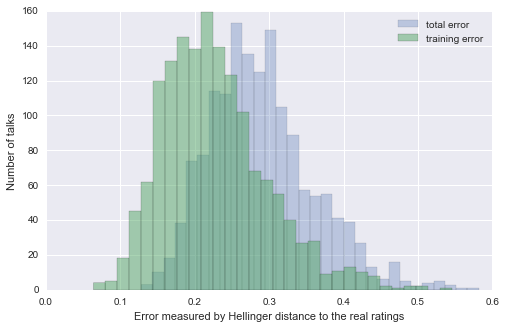

In [249]:
fig = plt.figure(figsize = (8,5))
ax = plt.gca()
avg_difference.hist(bins = 30,alpha = 0.3, label = 'total error',ax = ax)
training_error.hist(bins = 30,alpha = 0.5, label = 'training error', ax = ax)
ax.legend(loc = 'best',fontsize = 'medium')
plt.xlabel('Error measured by Hellinger distance to the real ratings')
plt.ylabel('Number of talks')

### Summary:
1. Some moderate amount of rating variations are explained by the topic differences among talks, as shown in the above figure and by comparing the mean training error from the model (0.23) vs the total error (0.29) if estimation is made using the global mean rating vector.
2. Evidently, a large portion of the rating variations are unexplained by a simple topic model. Outliers such as talk 129, which received predominantly one rating word: Jaw-dropping, may not be uncommon. Features that reflect other aspects of the talks, such as delivery skills may boost the prediction power.
3. Prediction on the test set is done in a separate notebook